In [9]:
import os, tqdm, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

In [2]:
df = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/evidential/evaluate/test_7.parquet")

In [3]:
true_labels = df["true_label"].values
pred_labels = df["pred_label"]
pred_probs = df[[f"pred_conf{k+1}" for k in range(4)]].values
confidences = df["pred_conf"]

evidential = df["evidential"]
total = np.sqrt(df["epistemic"] + df["aleatoric"])
epistemic = np.sqrt(df["epistemic"])
aleatoric = np.sqrt(df["aleatoric"])

df["total"] = total

In [4]:
df_det = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/evaluate/test_7.parquet")

In [5]:
n_splits = 10

ensemble_p = np.zeros((n_splits, df_det.shape[0]))
ensemble_std = np.zeros((n_splits, df_det.shape[0]))
ensemble_entropy = np.zeros((n_splits, df_det.shape[0]))
ensemble_mutual = np.zeros((n_splits, df_det.shape[0]))

# Loop over ensemble of parametric models
for split in tqdm.tqdm(range(n_splits)):
    dfe = pd.read_parquet(os.path.join("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier", "evaluate", f"test_{split}.parquet"))
    ensemble_p[split] = dfe["pred_conf"]
    ensemble_std[split] = dfe["epistemic"]
    ensemble_entropy[split] = dfe["entropy"]
    ensemble_mutual[split] = dfe["mutual_info"]

# Compute averages, uncertainties 
df_det["ave_conf"] = np.mean(ensemble_p, axis = 0)
df_det["ave_entropy"] = np.mean(ensemble_entropy, axis = 0)
df_det["ave_mutual_info"] = np.mean(ensemble_mutual, axis = 0)
df_det["epistemic"] = np.var(ensemble_p, axis = 0)
df_det["aleatoric"] = np.mean(ensemble_std, axis = 0)
df_det["total"] = df_det["epistemic"] + df_det["aleatoric"]

df_det["epistemic"] = np.sqrt(df_det["epistemic"])
df_det["aleatoric"] = np.sqrt(df_det["aleatoric"])
df_det["total"] = np.sqrt(df_det["total"])

100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


### Create composite soundings (top-5, 95, etc) using aleatoric, epistemic, total

In [ ]:
UNCERT_TYPE='total'
PROFILE_VAR='TEMP_C'

In [6]:
import sounding_utils

In [1]:
def extract_cols(df, plot_cols='TEMP_C'):
    all_cols = list(df.columns)
    data_cols = []
    for col in all_cols:
        if plot_cols in col: data_cols.append(col)
    return df[data_cols], data_cols

def skewCompositeFigAx(figsize=(10, 5)):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True,
                            subplot_kw=dict(projection="skewx", rotation=30),
                            figsize=figsize)
    axs[0].set_ylabel("Height above ground (m)")
    for ax in axs:
        ax.grid(which="both")

        major_ticks = np.arange(-100, 100, 5)
        ax.set_xticks(major_ticks)
        ax.grid(which="major", alpha=0.5)

        # minor_ticks = np.arange(xlowlim - 60, xhighlim, 1)
        # ax.set_xticks(minor_ticks, minor=True)
        # ax.grid(which='minor', alpha=0.2)

        ax.axvline(x=0, ymin=0, ymax=1, c="0")
        ax.set_ylim(-100, 5100)
        ax.set_xlim(-15, 30)

    return fig, axs

ptype_dict = {0: 'Rain',
      1: 'Snow',
      2: 'Sleet',
      3: 'Frz Rain'}

color_dict = {0: 'm',
              1: 'b',
              2: 'y',
              3: 'c'}

def plot_(fig, ax, df, uncert_percentile, best_uncert, title=''):
         #uncert_type='total', profile_var='TEMP_C'):

    uncert_type = UNCERT_TYPE
    profile_var = PROFILE_VAR
    for ptype in range(4):
        subdf = df[(df.pred_label == ptype)]
        top_quantile = subdf[uncert_type].quantile(q=uncert_percentile)
        
        if best_uncert: #take the best uncerts with uncert below quantile
            subdf = subdf[subdf[uncert_type] <= top_quantile]
        else:
            subdf = subdf[subdf[uncert_type] >= top_quantile]

        plot_data, data_cols = extract_cols(subdf)
        profile = plot_data.median()
        heights = [int(re.findall("(\d+)",txt)[0]) for txt in data_cols]

        (line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, linestyle='solid')
        
        line.set_label(
            (
                f'{ptype_dict[ptype]}'
            )
        )
    ax.set_xlabel(f'{profile_var}')
    ax.legend()
    ax.set_title(title)
    return fig,ax

# top 10% left
# bottom 10% right
# top 10 probability plots

# Plot Evidential and Det on on separate figures

Text(0.5, 0.98, 'Evidential Model')

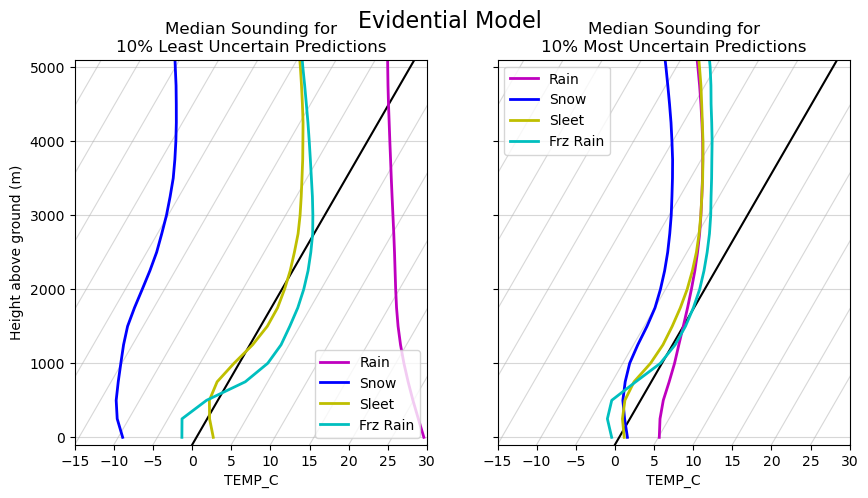

In [21]:
fig, axs = skewCompositeFigAx(figsize=(10, 5))
fig, axs[0] = plot_(fig, axs[0], df, 0.1, True, title="Median Sounding for\n10% Least Uncertain Predictions")
fig, axs[1] = plot_(fig, axs[1], df, 0.9, False, title="Median Sounding for\n10% Most Uncertain Predictions")
fig.suptitle('Evidential Model', fontsize=16)

Text(0.5, 0.98, 'Deterministic Model')

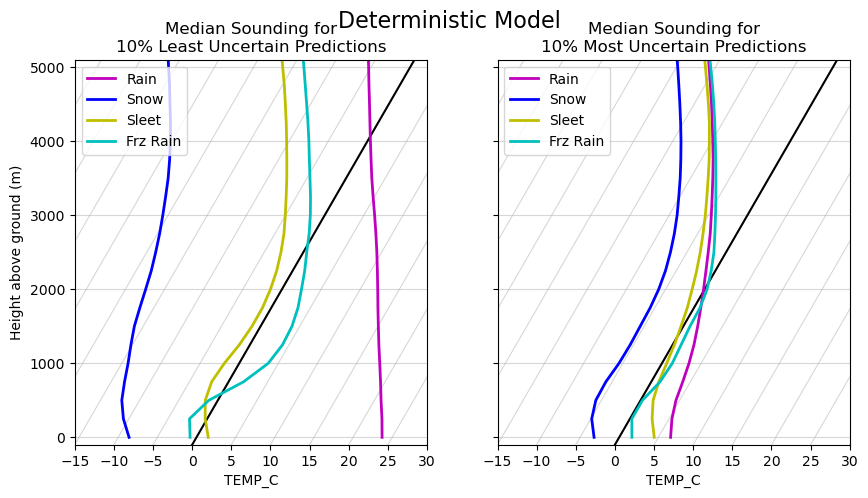

In [22]:
fig, axs = skewCompositeFigAx(figsize=(10, 5))
fig, axs[0] = plot_(fig, axs[0], df_det, 0.1, True, title="Median Sounding for\n10% Least Uncertain Predictions")
fig, axs[1] = plot_(fig, axs[1], df_det, 0.9, False, title="Median Sounding for\n10% Most Uncertain Predictions")
fig.suptitle('Deterministic Model', fontsize=16)

# Evidential and Det on same figure

Text(0.5, 0.98, 'Top 10% Least Uncertain Predictions')

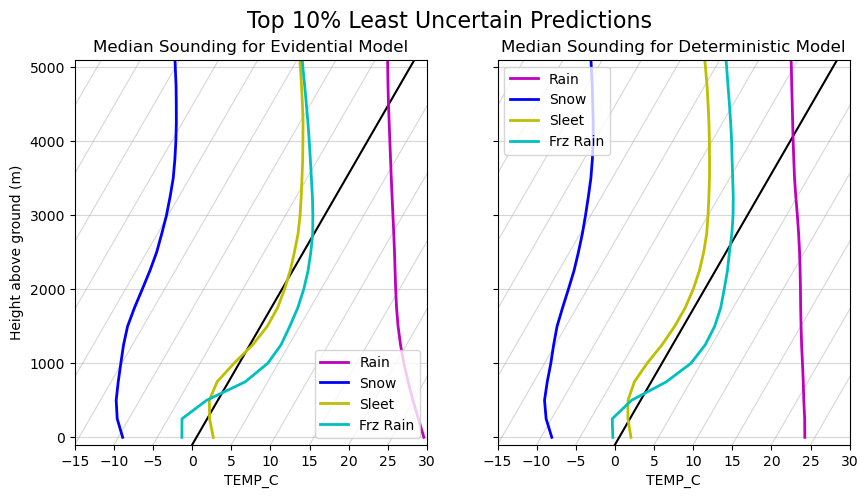

In [23]:
fig, axs = skewCompositeFigAx(figsize=(10, 5))
fig, axs[0] = plot_(fig, axs[0], df, 0.1, True, title="Median Sounding for Evidential Model")
fig, axs[1] = plot_(fig, axs[1], df_det, 0.1, True, title="Median Sounding for Deterministic Model")
fig.suptitle('Top 10% Least Uncertain Predictions', fontsize=16)

Text(0.5, 0.98, '10% Most Uncertain Predictions')

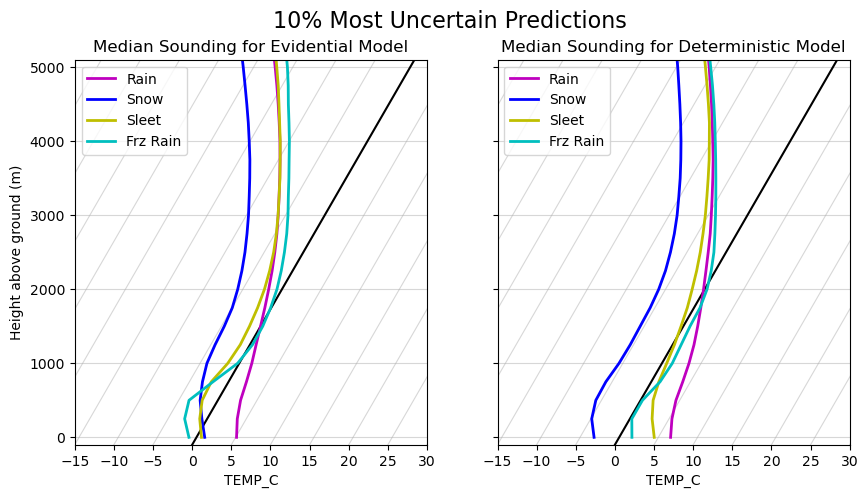

In [24]:
fig, axs = skewCompositeFigAx(figsize=(10, 5))
fig, axs[0] = plot_(fig, axs[0], df, 0.9, False, title="Median Sounding for Evidential Model")
fig, axs[1] = plot_(fig, axs[1], df_det, 0.9, False, title="Median Sounding for Deterministic Model")
fig.suptitle('10% Most Uncertain Predictions', fontsize=16)

# Plot all uncertainty levels on one figure for each model by varying alpha

In [14]:
def plot_uncerts(fig, ax, df, uncert_percentile, best_uncert, alpha, title=''):
                 #uncert_type='total', profile_var='TEMP_C'):
    uncert_type = UNCERT_TYPE
    profile_var = PROFILE_VAR
    for ptype in range(4):
        subdf = df[(df.pred_label == ptype)]
        top_quantile = subdf[uncert_type].quantile(q=uncert_percentile)
        
        if best_uncert: #take the best uncerts with uncert below quantile
            subdf = subdf[subdf[uncert_type] <= top_quantile]
        else:
            subdf = subdf[subdf[uncert_type] >= top_quantile]

        plot_data, data_cols = extract_cols(subdf)
        profile = plot_data.median()
        heights = [int(re.findall("(\d+)",txt)[0]) for txt in data_cols]

        (line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, linestyle='solid',
                         alpha=alpha)
        if alpha==1:
            line.set_label(
                (
                    f'{ptype_dict[ptype]}'
                )
            )
    ax.set_xlabel(f'{profile_var}')
    ax.set_title(title)
    return fig,ax

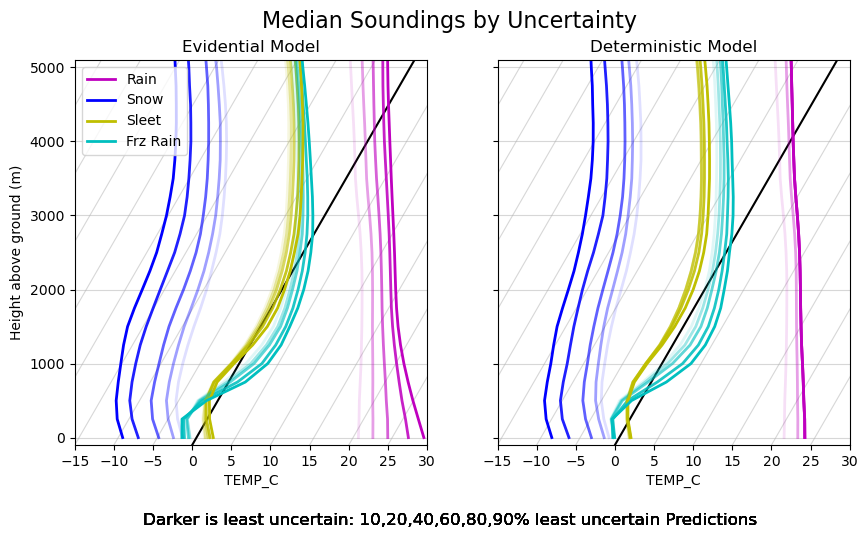

In [19]:
fig, axs = skewCompositeFigAx(figsize=(10, 5))
levels = list(np.arange(0.2,0.8,0.2)) + [0.1, 0.9]
for level in levels:
    percent = f'{level * 100:.0f}'
    alpha = -1 * ((level - 0.1) / 0.8 - 1)
    fig, axs[0] = plot_uncerts(fig, axs[0], df, level, True, alpha, title=f"Evidential Model")
    fig, axs[1] = plot_uncerts(fig, axs[1], df_det, level, True, alpha, title=f"Deterministic Model")
    fig.suptitle(f'Median Soundings by Uncertainty', fontsize=16)
    plt.figtext(0.5, -0.05, 'Darker is least uncertain: 10,20,40,60,80,90% least uncertain Predictions', 
                wrap=True, horizontalalignment='center', fontsize=12)
axs[0].legend()

# Plot various uncertainty levels, both models

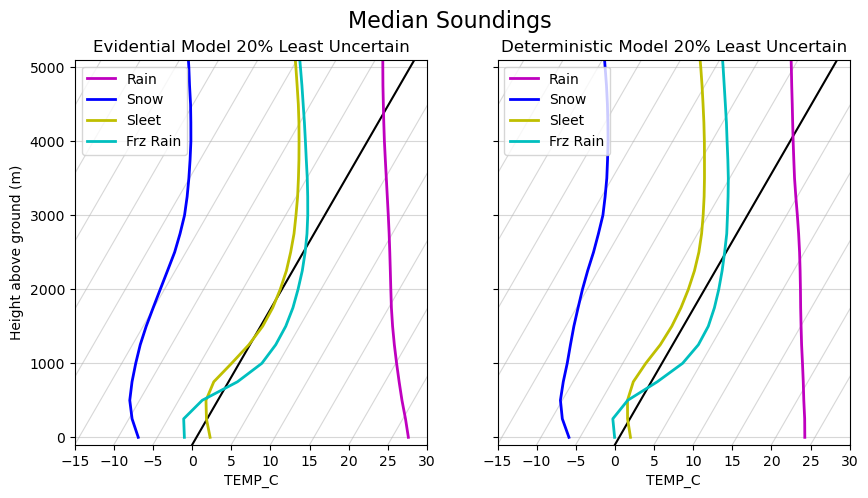

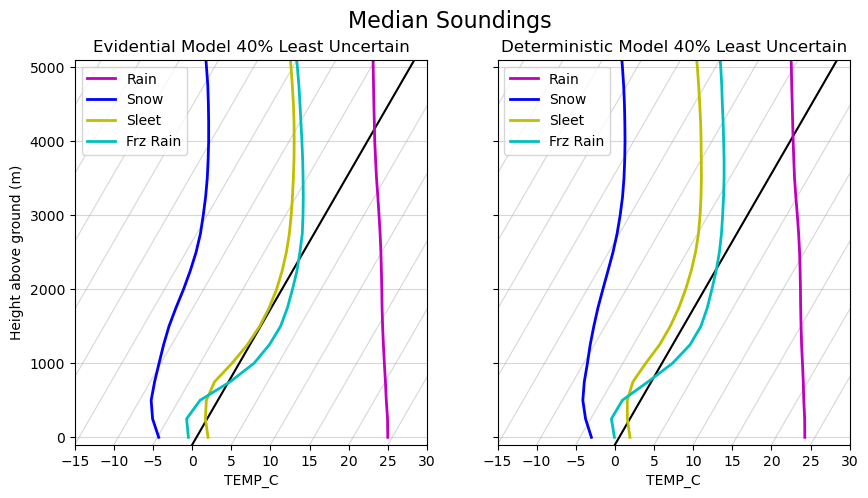

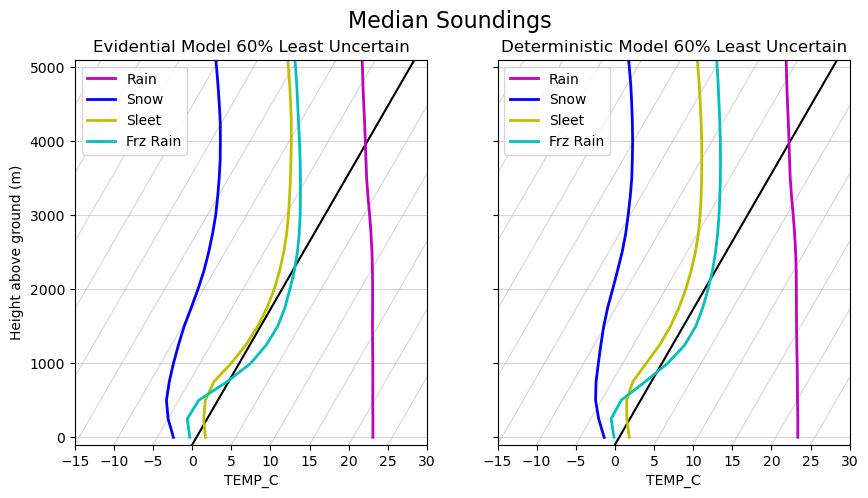

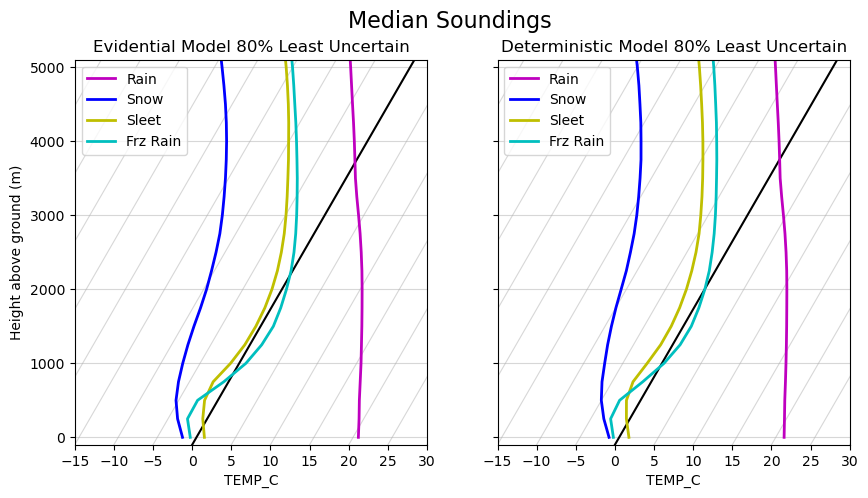

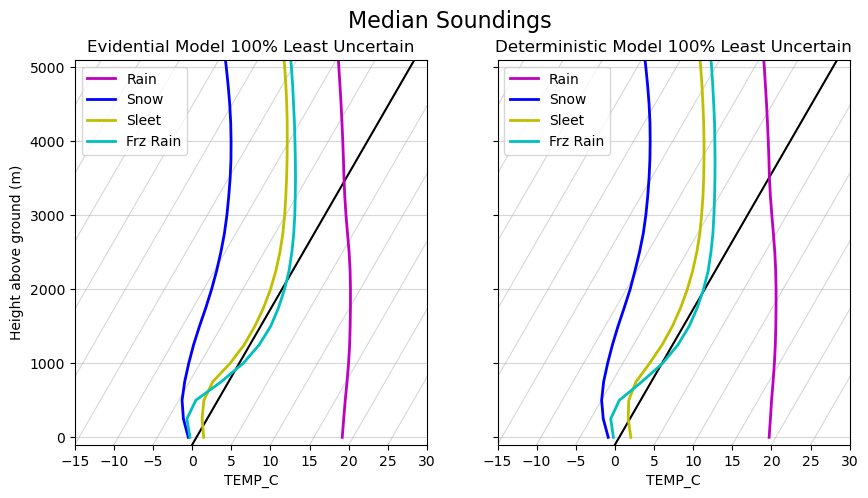

In [25]:
for level in np.arange(0.2,1.1,0.2):
    fig, axs = skewCompositeFigAx(figsize=(10, 5))
    percent = f'{level * 100:.0f}'
    fig, axs[0] = plot_(fig, axs[0], df, level, True, title=f"Evidential Model {percent}% Least Uncertain")
    fig, axs[1] = plot_(fig, axs[1], df_det, level, True, title=f"Deterministic Model {percent}% Least Uncertain")
    fig.suptitle(f'Median Soundings', fontsize=16)